<a href="https://colab.research.google.com/github/honeybeat1/ds-section1-project1/blob/main/ds_section1_project_vdgames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 게임 데이터 분석

프로젝트 목표 : 다음 분기에 어떤 게임을 설계해야 잘 팔릴까
- 매출이 높은 게임의 특성에 대해 알아보자

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

## 데이터 EDA
데이터를 열어보고, 분석에 맞게 각 칼럽의 타입을 변경하는 등의 전처리를 해줘야 한다.

1. 데이터 크기 (shape), 데이터 결측값 처리 (dropna)
2. 데이터 전처리 (타입 변경, replace)

In [2]:
data = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [3]:
data.shape

(16598, 9)

In [4]:
#연도는 str으로, Sales는 int로 변환해야 한다
data.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object

In [5]:
data.isna().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [6]:
#우선 NaN 드랍
df = data.dropna()

In [7]:
df.shape

(16241, 9)

In [8]:
df['Year'] = df['Year'].astype(int)
df['Year'].unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
          9,   97, 1995, 1993, 2012, 1987, 1982,   11, 1994, 1990,   15,
       1992, 1991, 1983, 1988, 1981,    3, 1989,   96,    6,    8, 1986,
          1,    5,    4,   10,   98,    7,   16,   86,   14,   95, 2017,
       1980, 2020,    2,   13,    0,   12,   94])

### Year 칼럼 전처리 조건
- Year 칼럼의 값은 크게 전처리 해줘야 하는 100이하의 값과 맞추는 기준이 되어줄 1980년에서 2020년까지 범위의 값이 있다.
- 1980년에서 2020년 사이의 값이 기준이기 때문에 10~16는 앞자리 20을 붙여주면 되며
- 86 ~ 98까지의 값은 앞자리 19를 붙여줄 수 있다
- 0~9 사이의 값은 19, 20 둘다 해당할 수 있기 때문에 과감히 드랍한다. 

In [9]:
#year값 0-9사이 행 drop
data_below10 = df[df['Year'] < 10]
df = df.drop(data_below10.index)

In [10]:
#원본에서 410행 (약 40%) 삭제
df.shape

(16188, 9)

In [11]:
#10~16 앞자리 20 붙여주기
df16idx = df[(df['Year'] <= 16) & (df['Year'] >= 10)].index
for i in df16idx:
    df.loc[i, 'Year'] = df.loc[i, 'Year'] + 2000
#86~98 앞자리 19 붙여주기
df19idx = df[(df['Year'] <= 98) & (df['Year'] >= 86)].index
for i in df19idx:
    df.loc[i, 'Year'] = df.loc[i, 'Year'] + 1900

In [ ]:
sorted(df['Year'].unique())

In [17]:
#index재정렬
df_reset = df.reset_index(drop=True)

In [18]:
df_reset.tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
16183,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0,0.01
16184,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0,0,0
16185,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16186,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03
16187,The King of Fighters '95,PS,1996,Fighting,Sony Computer Entertainment,0,0,0.16,0.01


(array([ 107.,   65.,   89.,  443., 1264., 2413., 3856., 5217., 2388.,
         346.]),
 array([1980., 1984., 1988., 1992., 1996., 2000., 2004., 2008., 2012.,
        2016., 2020.]),
 <a list of 10 Patch objects>)

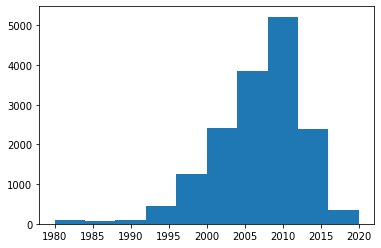

In [15]:
plt.hist(df['Year'])

- 주로 2005년에서 2010년 사이의 데이터가 가장 많이 분포하고 있음을 알 수 있다. 

### Sales 칼럼 전처리 조건
- M 기준 (K는 1000, M은 1000000 100만)
- M, K 지우고 100만 곱해주기, K인 경우 1000 곱해주기

In [20]:
#모든 매출 칼럼에 대하여 전처리
for i in df_reset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]:
    for j in range(len(df_reset)):
        if re.compile(r'K').search(df_reset[i].loc[j]): #K를 포함하고 있다면 1000 곱해주기
            df_reset[i].loc[j] = int(df_reset[i].loc[j].replace('K','')) * 1000
        elif re.compile(r'M').search(df_reset[i].loc[j]): #M을 포함하고 있다면 100만 곱해주기
            df_reset[i].loc[j] = float(df_reset[i].loc[j].replace('M', '')) * 1000000
        else: #그 외 M기준이므로 100만 곱해주기
            df_reset[i].loc[j] = float(df_reset[i].loc[j]) * 1000000

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [19]:
#바뀌기 전
df.loc[10]

Name                  Ford Racing
Platform                       PS
Year                         2001
Genre                      Racing
Publisher      Empire Interactive
NA_Sales                     480K
EU_Sales                    0.33M
JP_Sales                       0K
Other_Sales                  0.06
Name: 10, dtype: object

In [21]:
#바뀐 후
df_reset.loc[10]

Name                  Ford Racing
Platform                       PS
Year                         2001
Genre                      Racing
Publisher      Empire Interactive
NA_Sales                   480000
EU_Sales                   330000
JP_Sales                        0
Other_Sales                 60000
Name: 10, dtype: object

In [22]:
df_reset.dtypes

Name           object
Platform       object
Year            int64
Genre          object
Publisher      object
NA_Sales       object
EU_Sales       object
JP_Sales       object
Other_Sales    object
dtype: object

In [23]:
#object 타입 바꿔주기
df_reset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = df_reset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].astype(int)
df_reset['Year'] = df_reset['Year'].astype(str)

## 지역에 따라서 선호하는 게임 장르가 다를까?
- x 변수 장르, y 변수 지역 매출

In [24]:
sales_by_genre = df_reset.groupby('Genre').sum()
sales_by_genre

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,856209997,512659997,156230000,183679998
Adventure,101790000,63630000,51850000,16690000
Fighting,220109998,99720000,87090000,36100000
Misc,394369999,207870000,104110000,72569999
Platform,443179999,199569999,130269999,51160000
Puzzle,121159999,50440000,56190000,12410000
Racing,353709997,234269999,56320000,76260000
Role-Playing,318759999,183089998,342839999,56730000
Shooter,573349997,309959996,38180000,101680000


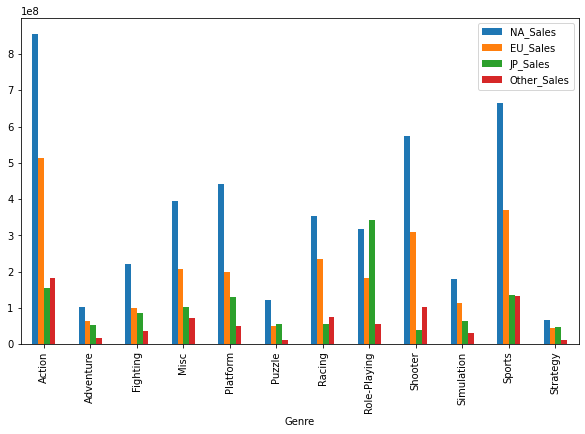

In [30]:
sales_by_genre.plot.bar(figsize=(10,6));

1. 북미 매출 기준 Action, Sports, Shooter, Platform 순으로 인기가 많다.
2. 유럽 매출 기준 Action, Sports, Shooter, Racing 순으로 인기가 많다.
3. 일본 매출 기준 Role-playing, Action, Sports, Platform 순으로 인기가 많다.
4. 기타 지역 매출 기준 Action, Sports, Shooter, Racing 순으로 인기가 많다.
----
- 일본 지역만 독특하게 Role-playing 장르의 매출이 독보적으로 높으며 북미, 유럽, 기타 지역은 Action, Sports, Shooter 장르가 순위권인 비슷한 경향을 보인다.
- 일본 지역만 Role-playing 장르의 매출이 높은 것은 **드래곤 퀘스트, 몬스터 헌터, 파이널 판타지 시리즈** 때문
- 일본에서 개발된 게임의 특수성 때문이므로 글로벌하게는 지역에 따라 선호하는 장르가 크게 다르지 않다고 말할 수 있다. 

In [33]:
#일본 지역 상위권 매출 게임
#일본에서만 판매된 게임도 있다
df_reset[df_reset['Genre'] == 'Role-Playing'].sort_values(by=['JP_Sales'], axis=0, ascending=False)[:15]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7649,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000,8890000,10220000,1000000
9198,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,Nintendo,9000000,6180000,7200000,710000
10307,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,Nintendo,6420000,4520000,6040000,1370000
10372,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5570000,3280000,5650000,820000
10660,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,Nintendo,6060000,3900000,5380000,500000
1810,Monster Hunter Freedom 3,PSP,2010,Role-Playing,Capcom,0,0,4870000,0
5089,Dragon Quest IX: Sentinels of the Starry Skies,DS,2009,Role-Playing,Nintendo,660000,690000,4350000,150000
4421,Monster Hunter Freedom Unite,PSP,2008,Role-Playing,Capcom,470000,570000,4130000,340000
159,Dragon Quest VII: Warriors of Eden,PS,2000,Role-Playing,Enix Corporation,200000,140000,4099999,20000
14772,Dragon Warrior III,NES,1988,Role-Playing,Enix Corporation,100000,0,3770000,0


## 연도별 게임 트렌드가 있을까?
게임 트렌드란?
1. 해당 연도 매출이 높은 게임의 장르
2. 해당 연도 발매가 제일 많이 된 게임의 장르
3. 연도 매출과 연도 발매량 간의 관계

In [344]:
#각 지역 매출 총 합을 나타내는 새로운 칼럼 'Sales_sum' 만들기
df_reset['Sales_sum'] = df_reset['NA_Sales'] + df_reset['EU_Sales'] + df_reset['JP_Sales'] + df_reset['Other_Sales']
df_reset_sum = df_reset[['Year', 'Genre', 'Sales_sum']]

In [345]:
#연도별, 장르별 매출 총 합
df_reset_sum.groupby(['Year', 'Genre']).sum()
df_reset_sum = df_reset_sum.groupby(['Year', 'Genre']).sum().sort_values(by=["Year", "Sales_sum"], ascending=[True, False])
df_reset_sum

Sales_sum
Year Genre                  
1980 Shooter         7070000
     Misc            2700000
     Fighting         770000
     Action           340000
1981 Action         14790000
...                      ...
2016 Strategy         520000
     Simulation       390000
2017 Role-Playing      40000
     Action            10000
2020 Simulation       290000

[388 rows x 1 columns]

In [347]:
#매년 가장 매출이 높았던 장르 상위 2개 뽑기
temp = []
years_list = []
for i in range(len(df_reset_sum)):
    if df_reset_sum.index[i][0] not in years_list:
        years_list.append(df_reset_sum.index[i][0])
for i in years_list:
    new = df_reset_sum.iloc[df_reset_sum.index.get_level_values('Year') == i].head(2)
    temp.append(new)
df_sales_first = temp[0]
for i in temp[1:]:
    df_sales_first = df_sales_first.append(i)
df_sales_first

Sales_sum
Year Genre                  
1980 Shooter         7070000
     Misc            2700000
1981 Action         14790000
     Shooter        10020000
1982 Puzzle         10040000
...                      ...
2016 Action         19840000
     Shooter        18169999
2017 Role-Playing      40000
     Action            10000
2020 Simulation       290000

[77 rows x 1 columns]

### 연도별 게임 장르 발매량으로 알아보는 게임 트렌드

In [283]:
df_game_count = df_reset[['Year', 'Genre','Name']].groupby(['Year','Genre']).count()
df_game_count = df_game_count.sort_values(by=["Year", "Name"], ascending=[True, False])

In [284]:
df_game_count = df_game_count.reset_index()
df_game_count

,Year,Genre,Name
0,1980,Misc,4
1,1980,Shooter,2
2,1980,Action,1
3,1980,Fighting,1
4,1981,Action,25
...,...,...,...
383,2016,Strategy,10
384,2016,Simulation,9
385,2017,Role-Playing,2
386,2017,Action,1


In [ ]:
df_game_count_arr = df_game_count.groupby(['Year', 'Genre']).sum().unstack().fillna(0).reset_index()
df_game_count_arr

In [303]:
#표 그리기 위한 준비
arr = {}

for i in years_list:
  arr1 = {i : list(df_game_count_arr[df_game_count_arr['Year']== i].values[0][1:].astype(int))}
  arr.update(arr1)
#연도 수가 너무 길기 때문에 80년대만 잘라서
import itertools as it
out = dict(list(arr.items())[0: 10])  
out

{'1980': [1, 0, 1, 4, 0, 0, 0, 0, 2, 0, 0, 0],
 '1981': [25, 0, 0, 0, 3, 2, 1, 0, 10, 1, 4, 0],
 '1982': [18, 0, 0, 1, 5, 3, 2, 0, 5, 0, 2, 0],
 '1983': [7, 1, 0, 1, 5, 1, 0, 0, 1, 0, 1, 0],
 '1984': [1, 0, 0, 1, 1, 3, 3, 0, 3, 0, 2, 0],
 '1985': [2, 0, 1, 0, 4, 4, 0, 0, 1, 1, 1, 0],
 '1986': [6, 0, 0, 0, 6, 0, 1, 1, 4, 0, 3, 0],
 '1987': [2, 1, 2, 0, 2, 0, 0, 3, 2, 0, 4, 0],
 '1988': [2, 0, 0, 0, 4, 1, 1, 3, 1, 1, 2, 0],
 '1989': [2, 0, 0, 1, 3, 5, 0, 2, 1, 0, 3, 0]}

In [288]:
#Discrete distribution as horizontal bar chart
def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

In [348]:
#1980년대 게임 매출
df_sales_first[:20]

Sales_sum
Year Genre                  
1980 Shooter         7070000
     Misc            2700000
1981 Action         14790000
     Shooter        10020000
1982 Puzzle         10040000
     Action          6500000
1983 Platform        6930000
     Sports          3200000
1984 Shooter        31100000
     Sports          6170000
1985 Platform       43170000
     Action          3520000
1986 Action         13740000
     Platform        9390000
1987 Fighting        5419999
     Role-Playing    4650000
1988 Platform       27730000
     Role-Playing    5880000
1989 Puzzle         37750000
     Platform       20659999

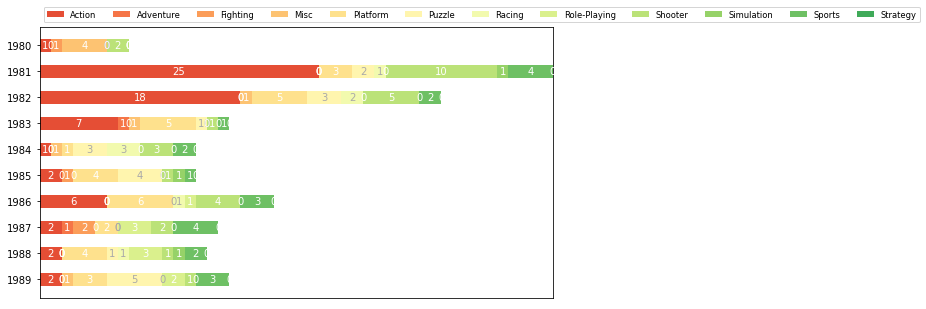

In [290]:
#1980년대 게임 발매량
results = dict(itertools.islice(arr.items(), 10))
category_names = sorted(df_reset['Genre'].unique())
survey(results, category_names)
plt.show()

1. 연도별로 발매된 게임, 매출이 높은 게임 장르가 다양하다.
2. 많이 발매 됐다고 매출 총 합이 높은 것은 아니며, 특히 82년의 경우 Action 장르 게임이 6배 많이 발매되었으나 매출은 1.5배 가량 적다
3. 연도별로 매출 1,2위 게임 장르가 다르다는 것은 게임 트렌드가 연도별로 달라진다는 뜻이다.

In [350]:
#90년대 비교
df_sales_first[20:40]

Sales_sum
Year Genre                  
1990 Platform       22980000
     Action          6390000
1991 Platform        7630000
     Action          6760000
1992 Fighting       15230000
     Platform       13410000
1993 Platform       18680000
     Fighting        8750000
1994 Platform       28760000
     Fighting        8470000
1995 Platform       16690000
     Fighting       14840000
1996 Role-Playing   43990000
     Platform       28230000
1997 Racing         31919999
     Sports         30040000
1998 Sports         41750000
     Action         39409999
1999 Role-Playing   47240000
     Racing         37190000

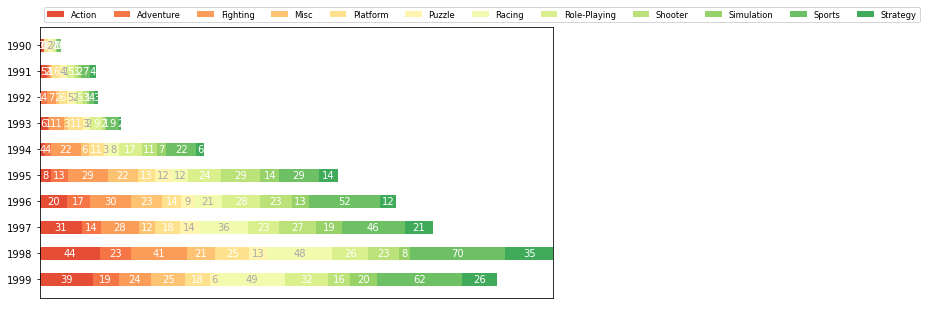

In [351]:
#90년대 게임 발매량
results = dict(list(arr.items())[10: 20])  
category_names = sorted(df_reset['Genre'].unique())
survey(results, category_names)
plt.show()

- 90년대 초는 Platform 게임이 매출에 강세를 보인다. 발매량은 다른 장르들과 차이가 없다. 
- 92년부터 95년까지는 1,2위를 모두 Platform과 Fighting 장르가 차지했다.
- 90년대 후반은 점차 Sports 게임이 발매를 많이 하기 시작했다. 매출 기준으로는 Role-playing, Racing, Sports 등 다양하다.

In [352]:
#00년대 비교
df_sales_first[40:60]

Sales_sum
Year Genre            
2000 Sports   41240000
     Action   33890000
2001 Action   56679999
     Racing   55129999
2002 Action   86650000
     Sports   65300000
2003 Action   67980000
     Sports   55500000
2004 Action   75940000
     Sports   61109998
2005 Action   85070000
     Misc     59689999
2006 Sports  136110000
     Misc     67230000
2007 Action  105990000
     Sports   98239999
2008 Action  134879999
     Sports   94909999
2009 Sports  138589999
     Action  138130000

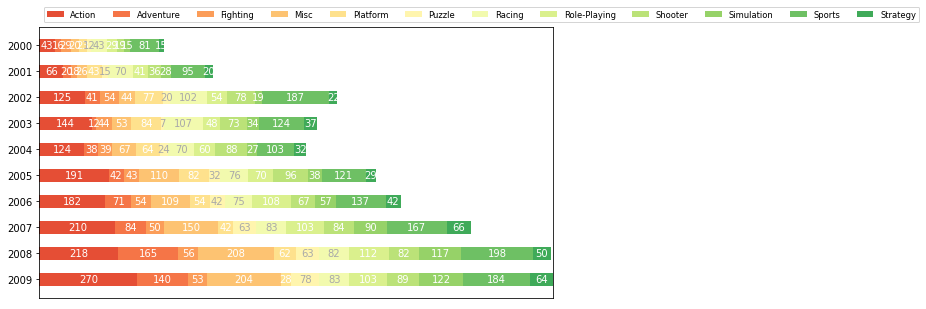

In [305]:
#2000년대 게임 발매량
results = dict(list(arr.items())[20: 30])  
category_names = sorted(df_reset['Genre'].unique())
survey(results, category_names)
plt.show()

- 2000년대는 확실한 Sports - Action 게임이 판매량, 발매량에서도 강세를 보인다. 
- Nintendo의 Wii 게임들이 매출 상위권에 랭크되었다. 
- Sports - Action 게임들이 다수 발매되기도 했지만, 영향력이 절대적이진 않다. Fighting 장르 게임도 비슷하게 발매되었으나, 매출은 상위권에 랭크 되지 못했다.

In [353]:
#2010년대 비교
df_sales_first[60:]

Sales_sum
Year Genre                  
2010 Action        117500000
     Sports         92020000
2011 Action        118999999
     Shooter        99350000
2012 Action        120779999
     Shooter        72840000
2013 Action        125209999
     Shooter        62730000
2014 Action         99009999
     Shooter        65989999
2015 Action         68250000
     Shooter        66119999
2016 Action         19840000
     Shooter        18169999
2017 Role-Playing      40000
     Action            10000
2020 Simulation       290000

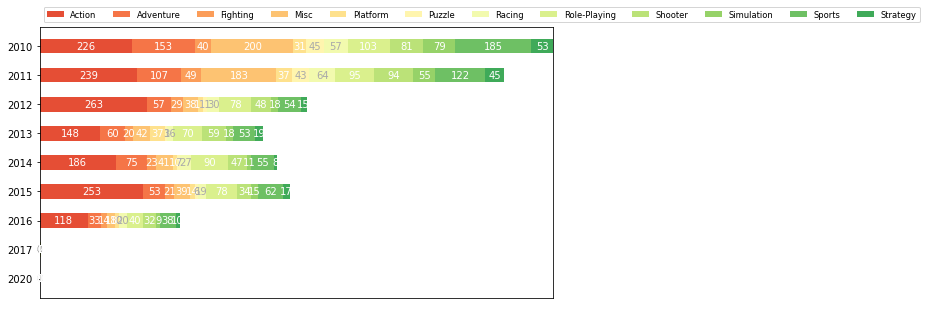

In [354]:
#2010년대 게임 발매량
results = dict(list(arr.items())[30: 40])  
category_names = sorted(df_reset['Genre'].unique())
survey(results, category_names)
plt.show()

- 발매된 게임 개수가 적어 분석할 수 없는 데이터인 2017년, 2020년을 제외하면
- 2010년대는 **Action - Shooter**게임이 확실한 강세를 보인다.
- 지표에서도 확인할 수 있듯이 인기에 힘입어 2010년대는 Action 게임이 가장 많이 발매되었다. 
- 2010년, 11년까지 Sports, Misc 장르의 게임도 다수 발매 되었으나 매출이 안나와서인지 발매 트렌드도 변했다.
- GTA 5(Action), 콜 오브 듀티 시리즈(Shooter)가 매출권 상위에 랭크되었다. 

#### 연도별 게임 트렌드 결론
- 80년대는 발매된 게임 개수 자체가 상대적으로 적기 때문에 장르보다는 게임 자체의 매출에 더 영향을 많이 받는다. 따라서 연도별로 매출 1위인 게임 장르가 다양하다. 
- 90년대 초는 Platform, Fighting 장르가 매출 순으로 강세를 보였다. 게임 자체의 발매량이 많아지면서 다양한 장르의 게임이 골고루 발매되었다. 그 중 1위는 Sports로, 90년대 후반에 매출 또한 증가했다.
- 2000년대 이후 부터는 인기있는 장르가 명확하다. 근래일수록 발매도 인기 있는 게임 장르 위주로 발매되었다.  00년대는 Sports-Action 장르가 확실한 대세이며, 10년대는 Action - Shooter 게임이 강세를 보인다.
- 따라서 게임 트랜드, 즉 매출이 높은 게임 장르는 10년 단위로 확인이 가능하다. 
- 8090년대는 다양한 게임 장르 발매 위주라면, 0010년대는 인기 있는 게임 장르 위주의 발매가 돋보인다.

### 발매된 게임 장르별 개수와 매출간의 관계
- 그래프를 그려 알아봤지만, 상관계수를 활용하여 알아보자.
- 가설 : 연도별로 더 많이 발매된 장르가 매출도 높을 것이다. 

In [370]:
#판매량 추가
df_reset_sum1 = df_reset[['Year', 'Genre', 'Sales_sum']]
df_reset_sum_count = df_reset_sum1.groupby(['Year', 'Genre']).sum().reset_index()
df_reset_sum_count['Count'] = df_reset[['Year', 'Genre', 'Name']].groupby(['Year','Genre']).count().reset_index()['Name']
df_reset_sum_count

,Year,Genre,Sales_sum,Count
0,1980,Action,340000,1
1,1980,Fighting,770000,1
2,1980,Misc,2700000,4
3,1980,Shooter,7070000,2
4,1981,Action,14790000,25
...,...,...,...,...
383,2016,Sports,14630000,38
384,2016,Strategy,520000,10
385,2017,Action,10000,1
386,2017,Role-Playing,40000,2


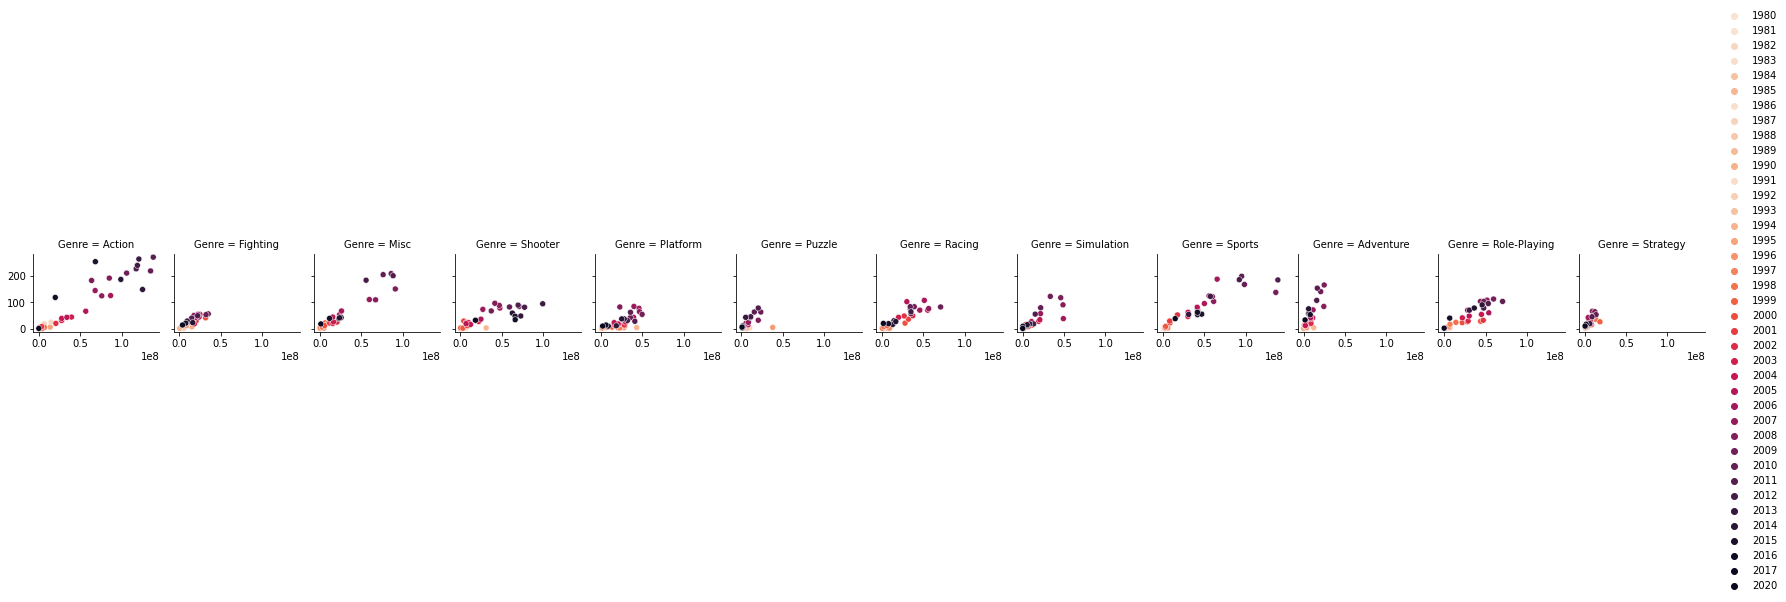

In [376]:
g = sns.FacetGrid(data = df_reset_sum_count, col= 'Genre', height=2)

g.map_dataframe(
    sns.scatterplot,
    x = 'Sales_sum',
    y = 'Count',
    hue = 'Year', # color
    #alpha = 0.5, # tranparency
    data = df_reset_sum_count,
    palette= 'rocket_r'
)
g.add_legend();

In [389]:
#매출-발매량 상관계수
df_reset_sum_count.corr()

,Sales_sum,Count
Sales_sum,1.000000,0.860166
Count,0.860166,1.000000


- 상관계수 값이 0.86이므로 전반적으로 다소 강한 양의 상관관계를 갖고 있다고 볼 수 있다.
- scatterplot을 보면 최근일수록, 절대적인 매출액이 클수록 상관 관계가 강해지는 것을 확인할 수 있다.
- 특히 매출이 높은 Action, Misc, Sports 장르의 경우 그런 경향이 두드러진다.

In [393]:
#장르별 매출-발매량 상관계수
for i in category_names:
  print(i, df_reset_sum_count[df_reset_sum_count['Genre'] == i].corr()['Count'][0])

Action 0.9315555149363534
Adventure 0.8215354277918471
Fighting 0.850386583921357
Misc 0.9549250141661138
Platform 0.6748008211592511
Puzzle 0.5371451265338018
Racing 0.8768977677399601
Role-Playing 0.8678144152033802
Shooter 0.8316253105679938
Simulation 0.8391536204950127
Sports 0.9179973351382784
Strategy 0.6779243046097714


- 반대로 상대적으로 발매량과 판매량의 상관관계가 약한 장르는 Puzzle, Platform, Strategy 등이 있다.

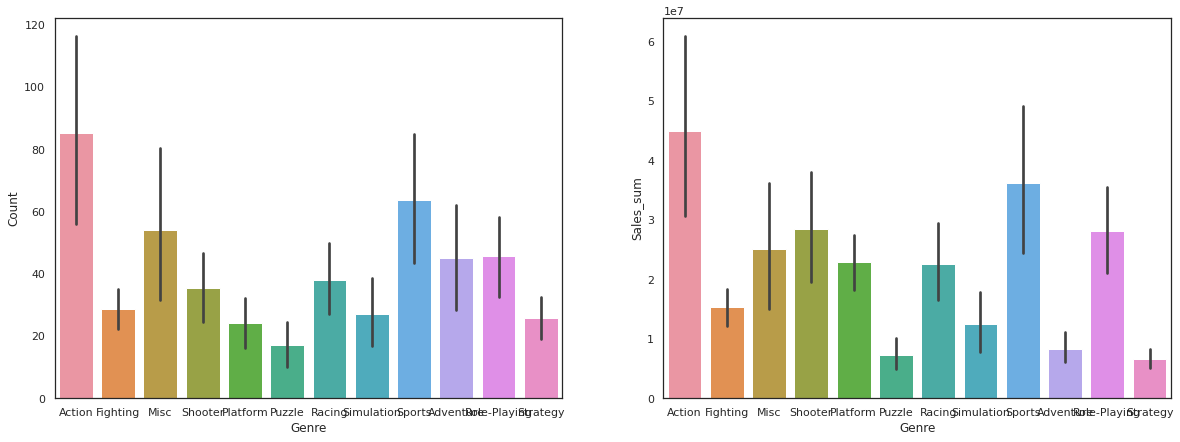

In [394]:
fig_dims = (20, 7)
fig, ax = plt.subplots(1,2,figsize=fig_dims)
sns.barplot(x='Genre', y='Count', ax=ax[0], data=df_reset_sum_count);
sns.barplot(x='Genre', y='Sales_sum', ax=ax[1], data=df_reset_sum_count);

- 발매량에 비해 매출이 안나오는 장르는 Adventure, Strategy이다.
- 발매량에 비해 매출이 잘 나오는 장르는 Platform, Shooter이다. 

### 게임 속성 Platform, Genre, Publisher 3개 중 가장 Sales에 영향을 끼치는 변수는? 
- categorical data의 경우, one-hot encoding을 통해 train/test 과정을 거쳐 알아볼 수 있으나
- 아직 배우지 않았으므로 Spearman correlation coefficient를 사용한다.
- 귀무가설 : 해당 변수와 Sales 변수는 연관이 없다.

In [395]:
#categorical data에 사용하는 spearman 상관계수 사용
platform = stats.spearmanr(df_reset.Sales_sum, df_reset.Platform)
publisher = stats.spearmanr(df_reset.Sales_sum, df_reset.Publisher)
Genre = stats.spearmanr(df_reset.Sales_sum, df_reset.Genre)
platform, Genre, publisher

(SpearmanrResult(correlation=0.074125175296287, pvalue=3.609994696208467e-21),
 SpearmanrResult(correlation=0.04723771979872315, pvalue=1.8207000018149926e-09),
 SpearmanrResult(correlation=0.03229797481861127, pvalue=3.9549959917748855e-05))

- Platform, Genre, publisher 모두 Sales에 영향을 끼치는 것을 알 수 있다.
- p-value가 모두 0.05 미만이므로 귀무가설인 '두 변수 간 연관이 없다'를 기각하며, 95%의 신뢰구간에서 두 변수 간 영향이 있다는 것을 채택할 수 있다. 

<BarContainer object of 16188 artists>

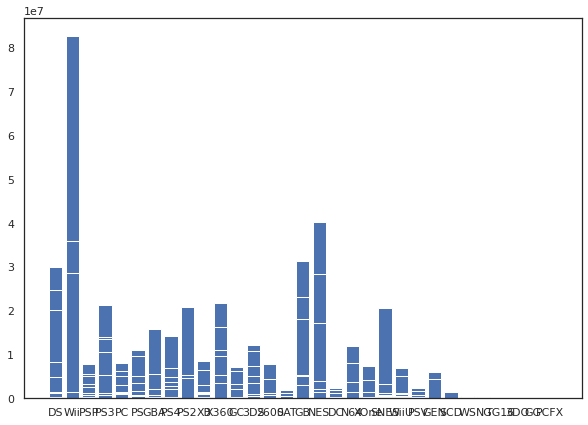

In [416]:
#플랫폼별 매출 분포
plt.figure(figsize=(10,7))
plt.bar(df_reset['Platform'], df_reset['Sales_sum'])

<BarContainer object of 16188 artists>

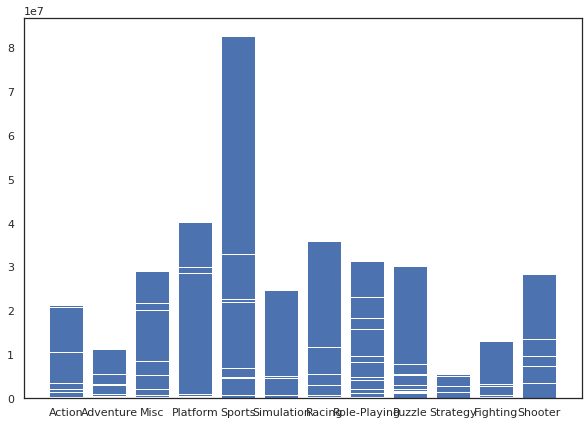

In [426]:
#장르별 매출 분포
plt.figure(figsize=(10,7))
plt.bar(df_reset['Genre'], df_reset['Sales_sum'])

<BarContainer object of 16188 artists>

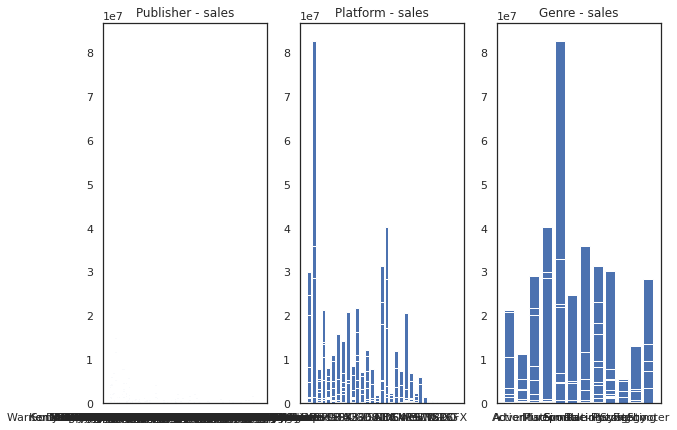

In [420]:
#배급사/플랫폼/장르에 따른 매출액 히스토그램 그리기
plt.figure(figsize=(10,7))
plt.subplot(1,3,1)
plt.title('Publisher - sales')
plt.bar(df_reset['Publisher'], df_reset['Sales_sum'])
plt.subplot(1,3,2)
plt.title('Platform - sales')
plt.bar(df_reset['Platform'], df_reset['Sales_sum'])
plt.subplot(1,3,3)
plt.title('Genre - sales')
plt.bar(df_reset['Genre'], df_reset['Sales_sum'])

- 대형 배급사, 혹은 대형 플랫폼, 특정 장르가 높은 sales를 보이고 있다.
- 그 중에 특히 Publisher의 경우 다수 배급사의 게임들의 총 매출이 적고 소수의 배급사가 많은 매출을 올리고 있기 때문에 그래프도 제대로 그려지지 않는다..
- Nintendo, EA 등의 대형 배급사가 매출을 이끌고 있으며, Publisher가 Sales에 큰 영향을 끼친다는 것을 알 수 있다.
- 종합하자면 가장 매출이 높은 게임은 Wii-sports로 [배급] Nintendo, [플랫폼] Wii, [장르] Sports 게임이다. 
- 해당 게임을 제외하면 나머지는 골고루 분포되어있다.

In [423]:
df_reset[['Publisher', 'Sales_sum']].groupby('Publisher').sum().sort_values(by='Sales_sum', ascending=False)[:10]

,Sales_sum
Publisher,
Nintendo,1759379992
Electronic Arts,1084229992
Activision,719179998
Sony Computer Entertainment,599579994
Ubisoft,472119998
Take-Two Interactive,398249997
THQ,338849999
Konami Digital Entertainment,277779998
Sega,269560000


In [425]:
df_reset.sort_values(by='Sales_sum', ascending=False)[:10]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum
2843,Wii Sports,Wii,2006,Sports,Nintendo,41490000,29020000,3770000,8460000,82740000
4097,Super Mario Bros.,NES,1985,Platform,Nintendo,29080000,3580000,6810000,770000,40240000
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
7649,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000,8890000,10220000,1000000,31380000
1184,Tetris,GB,1989,Puzzle,Nintendo,23200000,2260000,4220000,580000,30260000
6776,New Super Mario Bros.,DS,2006,Platform,Nintendo,11380000,9230000,6500000,2900000,30010000
2947,Wii Play,Wii,2006,Misc,Nintendo,14030000,9200000,2930000,2850000,29010000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
10242,Duck Hunt,NES,1984,Shooter,Nintendo,26930000,630000,280000,470000,28310000


In [430]:
wtf = df_reset.drop(index=2843)

In [431]:
wtf.sort_values(by='Sales_sum', ascending=False)[:10]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_sum
4097,Super Mario Bros.,NES,1985,Platform,Nintendo,29080000,3580000,6810000,770000,40240000
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
7649,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000,8890000,10220000,1000000,31380000
1184,Tetris,GB,1989,Puzzle,Nintendo,23200000,2260000,4220000,580000,30260000
6776,New Super Mario Bros.,DS,2006,Platform,Nintendo,11380000,9230000,6500000,2900000,30010000
2947,Wii Play,Wii,2006,Misc,Nintendo,14030000,9200000,2930000,2850000,29010000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
10242,Duck Hunt,NES,1984,Shooter,Nintendo,26930000,630000,280000,470000,28310000
10876,Nintendogs,DS,2005,Simulation,Nintendo,9070000,11000000,1930000,2750000,24750000


<BarContainer object of 16187 artists>

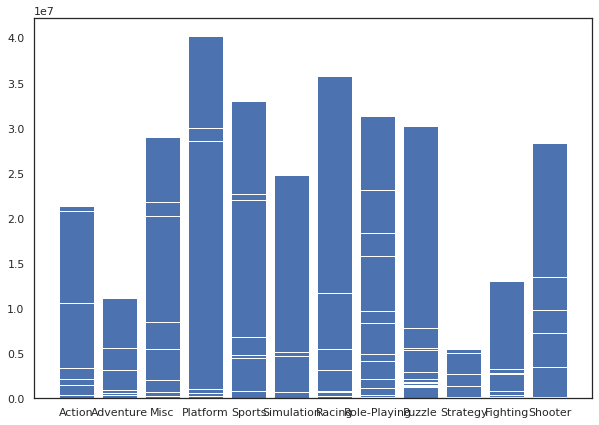

In [432]:
#닌텐도의 위 스포츠를 제외한 장르 - 매출 그래프
plt.figure(figsize=(10,7))
plt.bar(wtf['Genre'], wtf['Sales_sum'])

<BarContainer object of 16187 artists>

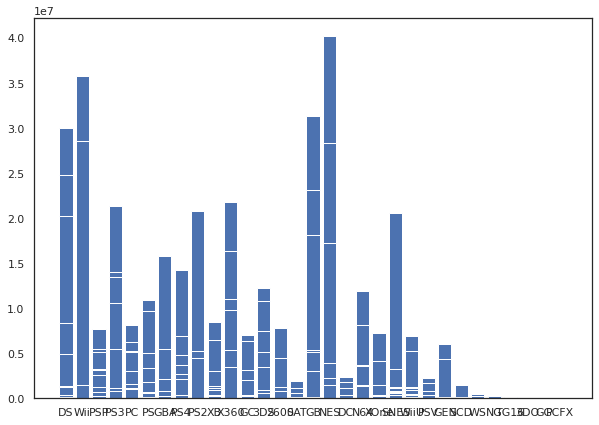

In [433]:
#닌텐도 위 스포츠를 제외한 플랫폼 - 매출액 그래프.
#매출액 2위인 슈퍼 마리오 브로스의 NES가 가장 높다.
plt.figure(figsize=(10,7))
plt.bar(wtf['Platform'], wtf['Sales_sum'])